<a href="https://colab.research.google.com/github/Mayank-goyal2424/Learning.it/blob/master/real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras

import numpy as np
import matplotlib.pyplot


from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing import image
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import Model
import timeit

import warnings
warnings.filterwarnings('ignore')

In [6]:
batch_size = 128
num_classes = 10
epochs = 2

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary c

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
def conv_(img, conv_filter):
    filter_size = conv_filter.shape[1]
    result = numpy.zeros((img.shape))
    #Looping through the image to apply the convolution operation.
    for r in numpy.uint16(numpy.arange(filter_size/2.0, 
                          img.shape[0]-filter_size/2.0+1)):
        for c in numpy.uint16(numpy.arange(filter_size/2.0, 
                                           img.shape[1]-filter_size/2.0+1)):
            """
            Getting the current region to get multiplied with the filter.
            How to loop through the image and get the region based on 
            the image and filer sizes is the most tricky part of convolution.
            """
            curr_region = img[r-numpy.uint16(numpy.floor(filter_size/2.0)):r+numpy.uint16(numpy.ceil(filter_size/2.0)), 
                              c-numpy.uint16(numpy.floor(filter_size/2.0)):c+numpy.uint16(numpy.ceil(filter_size/2.0))]
            #Element-wise multipliplication between the current region and the filter.
            curr_result = curr_region * conv_filter
            conv_sum = numpy.sum(curr_result) #Summing the result of multiplication.
            result[r, c] = conv_sum #Saving the summation in the convolution layer feature map.
            
    #Clipping the outliers of the result matrix.
    final_result = result[numpy.uint16(filter_size/2.0):result.shape[0]-numpy.uint16(filter_size/2.0), 
                          numpy.uint16(filter_size/2.0):result.shape[1]-numpy.uint16(filter_size/2.0)]
    return final_result

In [0]:
def conv(img, conv_filter):
    if len(img.shape) > 2 or len(conv_filter.shape) > 3: # Check if number of image channels matches the filter depth.
        if img.shape[-1] != conv_filter.shape[-1]:
            print("Error: Number of channels in both image and filter must match.")
            sys.exit()
    if conv_filter.shape[1] != conv_filter.shape[2]: # Check if filter dimensions are equal.
        print('Error: Filter must be a square matrix. I.e. number of rows and columns must match.')
        sys.exit()
    if conv_filter.shape[1]%2==0: # Check if filter diemnsions are odd.
        print('Error: Filter must have an odd size. I.e. number of rows and columns must be odd.')
        sys.exit()

    # An empty feature map to hold the output of convolving the filter(s) with the image.
    feature_maps = numpy.zeros((img.shape[0]-conv_filter.shape[1]+1, 
                                img.shape[1]-conv_filter.shape[1]+1, 
                                conv_filter.shape[0]))

    # Convolving the image by the filter(s).
    for filter_num in range(conv_filter.shape[0]):
        print("Filter ", filter_num + 1)
        curr_filter = conv_filter[filter_num, :] # getting a filter from the bank.
        """ 
        Checking if there are mutliple channels for the single filter.
        If so, then each channel will convolve the image.
        The result of all convolutions are summed to return a single feature map.
        """
        if len(curr_filter.shape) > 2:
            conv_map = conv_(img[:, :, 0], curr_filter[:, :, 0]) # Array holding the sum of all feature maps.
            for ch_num in range(1, curr_filter.shape[-1]): # Convolving each channel with the image and summing the results.
                conv_map = conv_map + conv_(img[:, :, ch_num], 
                                  curr_filter[:, :, ch_num])
        else: # There is just a single channel in the filter.
            conv_map = conv_(img, curr_filter)
        feature_maps[:, :, filter_num] = conv_map # Holding feature map with the current filter.
    return feature_maps # Returning all feature maps.

In [0]:
def pooling(feature_map, size=2, stride=2):
    #Preparing the output of the pooling operation.
    pool_out = numpy.zeros((numpy.uint16((feature_map.shape[0]-size+1)/stride+1),
                            numpy.uint16((feature_map.shape[1]-size+1)/stride+1),
                            feature_map.shape[-1]))
    for map_num in range(feature_map.shape[-1]):
        r2 = 0
        for r in numpy.arange(0,feature_map.shape[0]-size+1, stride):
            c2 = 0
            for c in numpy.arange(0, feature_map.shape[1]-size+1, stride):
                pool_out[r2, c2, map_num] = numpy.max([feature_map[r:r+size,  c:c+size]])
                c2 = c2 + 1
            r2 = r2 +1
    return pool_out

In [0]:
def relu(feature_map):
    #Preparing the output of the ReLU activation function.
    relu_out = numpy.zeros(feature_map.shape)
    for map_num in range(feature_map.shape[-1]):
        for r in numpy.arange(0,feature_map.shape[0]):
            for c in numpy.arange(0, feature_map.shape[1]):
                relu_out[r, c, map_num] = numpy.max([feature_map[r, c, map_num], 0])
    return relu_out

In [0]:
l1_filter = np.zeros((2,3,3))

In [0]:
l1_filter[0, :, :] = np.array([[[-1, 0, 1], 
                                   [-1, 0, 1], 
                                   [-1, 0, 1]]])
#Horizontal Edge Detection Filter
l1_filter[1, :, :] = np.array([[[1,   1,  1], 
                                   [0,   0,  0], 
                                   [-1, -1, -1]]])

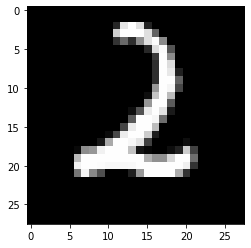

In [22]:
import pylab as plt

plt.imshow(x_train[122].reshape(28,28),cmap='gray')
plt.show()


In [0]:
l1_feature_map = conv(img, l1_filter)

In [0]:
l1_feature_map_relu = relu(l1_feature_map)

In [0]:
l1_feature_map_relu_pool = pooling(l1_feature_map_relu, 2, 2)

In [0]:
import numpy
def model():
  img=?
  l1_filter = np.zeros((2,3,3))
  l1_filter[0, :, :] = np.array([[[-1, 0, 1], 
                                   [-1, 0, 1], 
                                   [-1, 0, 1]]])
  #Horizontal Edge Detection Filter
  l1_filter[1, :, :] = np.array([[[1,   1,  1], 
                                   [0,   0,  0], 
                                   [-1, -1, -1]]])
  l1_feature_map = conv(img, l1_filter)
  l1_feature_map_relu = relu(l1_feature_map)
  l1_feature_map_relu_pool = pooling(l1_feature_map_relu, 2, 2)
  l2_filter = numpy.random.rand(3, 5, 5, l1_feature_map_relu_pool.shape[-1])
  #print("\n**Working with conv layer 2**")
  l2_feature_map = conv(l1_feature_map_relu_pool, l2_filter)
  #print("\n**ReLU**")
  l2_feature_map_relu = relu(l2_feature_map)
  #print("\n**Pooling**")
  l2_feature_map_relu_pool = pooling(l2_feature_map_relu, 2, 2)
  #print("**End of conv layer 2**\n")